In [1]:
# Imports and global variables
import requests
import json
import pandas as pd
from dateutil import parser

BASE_URL = "http://localhost:8080/engine-rest"

In [37]:
# CLEANUP
# delete all process definitions and running instances
# ! we need to delete all the running instances first

def status_code_successful(status_code: int):
    return str(status_code)[0] == '2'


def delete_all_data(target: str):
    POSSIBLE_TARGETS = ["process-instance", "process-definition", "deployment", "decision-definition"]
    if target not in POSSIBLE_TARGETS:
        raise Exception(str(target) + "not a valid data deletion target")
        
    get_response = requests.get(BASE_URL + "/" + target)
    assert(status_code_successful(get_response.status_code))
    #print(json.dumps(get_response.json(), indent=2))

    for elem in get_response.json():
        current_id = elem.get('id')
        del_response = requests.delete(BASE_URL + "/" + target + "/" + str(current_id))
        #print(del_response)
        assert(status_code_successful(del_response.status_code))

    
    get_response = requests.get(BASE_URL + "/" + target)
    assert(status_code_successful(get_response.status_code))
    assert(len(get_response.json()) == 0)   

    
for elem in ["process-instance", "process-definition", "deployment", "decision-definition"]:
    delete_all_data(elem)



In [38]:
# deploy ONE example process 
# TODO: extent for multiple

multipart_form_data = { 
    'deployment-name': (None, 'store'),
    'data': ('fast_a_better_vB.bpmn', open('../api-tests/resources/bpmn/fast_a_better/fast_a_better_vB.bpmn', 'r')),
}

response = requests.post(BASE_URL + "/deployment/create", files=multipart_form_data)
assert(status_code_successful(response.status_code))

#print(json.dumps(response.json(), indent=2))
for elem in response.json().get('deployedProcessDefinitions'):
    new_process_id = elem

print(new_process_id)

Process_09t18o7:1:6a49d5e3-9a69-11ec-bc1f-0242ac120002


In [39]:
from time import sleep
# start batch of instances
for x in range(100):
    headers = {'Content-Type': 'application/json'}
    response = requests.post("http://localhost:8080/engine-rest/process-definition/" + str(new_process_id)+ "/start", headers=headers)
    #print(json.dumps(response.json(), indent=2))
    assert(status_code_successful(response.status_code))
    sleep(1)



In [40]:
# poll history service
# calculate durations of process instances by process definition
import datetime as dt

proc_def_response = requests.get(BASE_URL + "/history/process-definition/cleanable-process-instance-report")
assert(status_code_successful(proc_def_response.status_code))
#print(json.dumps(proc_def_response.json(), indent=2))

historic_df = pd.DataFrame(columns=['processDefinitionId', 'processDefinitionKey', 'processDefinitionName', 'Duration'])

for elem in proc_def_response.json():
    processDefinitionId = elem.get('processDefinitionId')
    if new_process_id == str(processDefinitionId):
        processDefinitionKey = elem.get('processDefinitionKey')
        processDefinitionName = elem.get('processDefinitionName')
        params = {'processDefinitionId': str(processDefinitionId)}
        proc_inst_response = requests.get(BASE_URL + "/history/process-instance", params=params)
        assert(status_code_successful(proc_inst_response.status_code))
        for elem2 in proc_inst_response.json():
            end_datetime = parser.parse(elem2.get('endTime'))
            start_datetime = parser.parse(elem2.get('startTime'))
            duration = (end_datetime - start_datetime).total_seconds()
            historic_df.loc[len(historic_df)] = [processDefinitionId, processDefinitionKey, processDefinitionName, duration]
        
print(historic_df)
csv_name = 'fast_a_better_vB_100.csv'
historic_df.to_csv(csv_name, index=False)
# Calculate mean of duration of all instances
print("Mean: " + str((historic_df.Duration.mean())))

                                  processDefinitionId processDefinitionKey  \
0   Process_09t18o7:1:6a49d5e3-9a69-11ec-bc1f-0242...      Process_09t18o7   
1   Process_09t18o7:1:6a49d5e3-9a69-11ec-bc1f-0242...      Process_09t18o7   
2   Process_09t18o7:1:6a49d5e3-9a69-11ec-bc1f-0242...      Process_09t18o7   
3   Process_09t18o7:1:6a49d5e3-9a69-11ec-bc1f-0242...      Process_09t18o7   
4   Process_09t18o7:1:6a49d5e3-9a69-11ec-bc1f-0242...      Process_09t18o7   
..                                                ...                  ...   
95  Process_09t18o7:1:6a49d5e3-9a69-11ec-bc1f-0242...      Process_09t18o7   
96  Process_09t18o7:1:6a49d5e3-9a69-11ec-bc1f-0242...      Process_09t18o7   
97  Process_09t18o7:1:6a49d5e3-9a69-11ec-bc1f-0242...      Process_09t18o7   
98  Process_09t18o7:1:6a49d5e3-9a69-11ec-bc1f-0242...      Process_09t18o7   
99  Process_09t18o7:1:6a49d5e3-9a69-11ec-bc1f-0242...      Process_09t18o7   

   processDefinitionName  Duration  
0          helicopter_vB  

Min value: 2.023
Max value: 6.039
Mean: 2.1386499999999997
Median: 2.0605


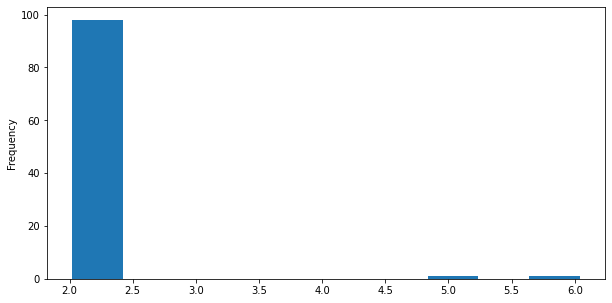

In [41]:
df = pd.read_csv(csv_name)
min_duration = df['Duration'].min()
max_duration = df['Duration'].max()
mean = df['Duration'].mean()
median = df['Duration'].median()

print(f'Min value: {min_duration}')
print(f'Max value: {max_duration}')
print(f'Mean: {mean}')
print(f'Median: {median}')

ax = df['Duration'].plot(kind="hist", figsize=(10,5), xlabel='Duration')
ax.figure.savefig('fast_a_better_vB_dist_100.pdf')